In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

from _context import vidlu
from vidlu.utils.presentation.figstyle import figsize

C:\Users\Ivan\Miniconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Homoscedastic and heteroscedastic noise

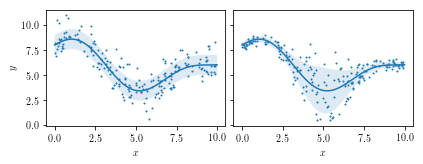

In [2]:
x = np.linspace(0, 10, num=200)
f = lambda x: sin(x)+2*cos(x/2)+6
e = lambda x: 2*exp(-(x-5)**2/3)+0.3
y = np.array([f(x) for x in x])
ye = np.array([e(x) for x in x])

x_samples = np.random.rand(200)*10
y_samples = np.array([f(x) for x in x_samples])
ye_heterosced_samples = np.array([f(x)+np.random.randn()*e(x) for x in x_samples])
ye_homosced_samples = np.array([f(x)+np.random.randn() for x in x_samples])

w, h = figsize()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(w,h*0.6))

ax1.fill_between(x, y-1, y+1, facecolor='C0', alpha=0.15, lw=0, interpolate=False)
ax1.plot(x, y, color='C0')
ax1.scatter(x_samples, ye_homosced_samples, s=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.fill_between(x, y-ye, y+ye, facecolor='C0', alpha=0.15, lw=0, interpolate=False)
ax2.plot(x, y, color='C0')
ax2.scatter(x_samples, ye_heterosced_samples, s=1)
ax2.set_xlabel('$x$')

fig.tight_layout(pad=0.1)

# \includegraphics[width=1.0\textwidth,transpaent]{figure.pdf}

In [3]:
os.makedirs('./data/plots/', exist_ok=True)
fig.savefig('./data/plots/homoscedastic-heteroscedastic-noises.pdf')

## KL-divergence asymmetry and minimization

0/5
1 0.028959857 [1.1168147 1.0483903] [2.5856292 5.969509 ] [6.4808191e-05 6.5461245e-05 6.6119719e-05 6.6784043e-05 6.7453853e-05]
2 0.08310864 [3.736569  4.8815994] [0.8689638 3.3520856] [6.4808191e-05 6.5461245e-05 6.6119719e-05 6.6784043e-05 6.7453853e-05]
1/5
1 0.01976136 [0.46819884 0.47967863] [2.8874621 2.8899462] [3.1199601e-05 3.1600957e-05 3.2006923e-05 3.2417513e-05 3.2832773e-05]
2 0.05269621 [3.4891062 3.3923998] [0.7687009 2.8952339] [3.1199601e-05 3.1600957e-05 3.2006923e-05 3.2417513e-05 3.2832773e-05]
2/5
1 0.019657666 [0.39545417 0.40718147] [2.8805861 2.8830643] [7.2755171e-07 7.4219275e-07 7.5710943e-07 7.7230584e-07 7.8778760e-07]
2 0.036712963 [3.585904  2.4046836] [0.74096125 2.3043227 ] [7.2755171e-07 7.4219275e-07 7.5710943e-07 7.7230584e-07 7.8778760e-07]
3/5
1 0.01960223 [0.34277892 0.35477433] [2.8771694 2.8798912] [7.4756521e-05 7.5835269e-05 7.6928038e-05 7.8034958e-05 7.9156285e-05]
2 0.02869093 [3.6243014 1.5192325] [0.7597412 2.578195 ] [7.4756521e-0

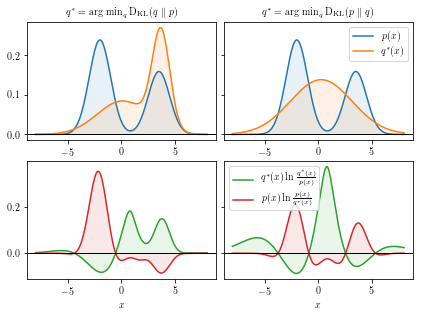

In [54]:
def klam():
    normal = lambda m, s: (lambda x: 1/((2*np.pi)**0.5*s)*torch.exp(-(x-m)**2/(2*s**2)))
    
    # fixed distribution
    p = lambda x: 0.6*normal(-2.0, 1)(x) + 0.4*normal(3.5, 1)(x)
    
    # variable approximating distribution
    mixture_components_count = 2
    params1 = [torch.tensor([v]*mixture_components_count, requires_grad=True) for v in [0., 1.]] # (mean, logstd) pairs
    m1, logs1 = params1
    params2 = [torch.tensor([v]*mixture_components_count, requires_grad=True) for v in [0., 1.]] # (mean, logstd) pairs
    m2, logs2 = params2
    
    params = params1 + params2

    with torch.no_grad():
        for param in [m1, m2]:
            param.add_(torch.randn(mixture_components_count)*torch.tensor([3.]))  # (mean, logstd)
        for param in [logs1, logs2]:
            param.add_(torch.randn(mixture_components_count)*torch.tensor([0.5]))  # (mean, logstd)


    # KL-divergence sub-integral function
    dkl_sub = lambda p, q: (lambda x: p(x)*torch.log(p(x)/q(x)))
    #ce_sub = lambda p, q: (lambda x: -p(x)*torch.log(q(x)))  # !!! TODO: UNDO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #dkl_sub = ce_sub
    
    lr = 2e-2
    optimizer = optim.SGD(params, lr=lr, momentum=0.9)
    
    
    iter_count = 100000
    for i in range(iter_count):
        #xs = torch.rand(1000)*20-10
        xs = torch.linspace(-10, 10, steps=2000)
          
        s1 = torch.exp(logs1)
        s2 = torch.exp(logs2)
        q1 = lambda x: sum(normal(m, s)(x) for m, s in zip(m1, s1)) / mixture_components_count
        q2 = lambda x: sum(normal(m, s)(x) for m, s in zip(m2, s2)) / mixture_components_count
    
        losses_pq = dkl_sub(p, q1)(xs)
        losses_qp = dkl_sub(q2, p)(xs)
        loss1 = losses_pq.mean()
        loss2 = losses_qp.mean()
        loss = loss1 + loss2

        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(params, 1e-3/(i+1)**0.5/lr)
        for v in params:
            v.grad.data[v.grad.data!=v.grad.data] = 0
            #v.data.add_(-lr, v.grad.data)
        optimizer.step()
        
        if i % (iter_count//5) == 0:
            print(f"{i*5//iter_count}/5")
            print(1, loss1.detach().numpy(), m1.detach().numpy(), s1.detach().numpy(), losses_qp.detach().numpy()[:5])
            print(2, loss2.detach().numpy(), m2.detach().numpy(), s2.detach().numpy(), losses_qp.detach().numpy()[:5])
    
    # Plotting

    x = torch.linspace(-8, 8, steps=400)
    yp = torch.stack(list(map(p, x)))
    yq1 = torch.stack(list(map(q1, x)))
    yq2 = torch.stack(list(map(q2, x)))

    dkl_subqp1 = dkl_sub(q1,p)(x).detach().numpy()
    dkl_subpq1 = dkl_sub(p,q1)(x).detach().numpy()

    dkl_subqp2 = dkl_sub(q2,p)(x).detach().numpy()
    dkl_subpq2 = dkl_sub(p,q2)(x).detach().numpy()

    x = x.numpy()

    w, h = figsize()

    def plot_filled(ax, x, y, color, label='$y$'):
        ax.fill_between(x, 0, y, facecolor=color, alpha=0.1, lw=0, interpolate=False)
        ax.plot(x, y, color=color, label=label)

    fig, axes = plt.subplots(2, 2, sharey='row', figsize=(w, h*0.6*2))
    plot_filled(axes[0,0], x, yp.detach().numpy(), 'C0', r'$p(x)$')
    plot_filled(axes[0,0], x, yq2.detach().numpy(), 'C1', r'$q^*(x)$')
    axes[0,0].set_title(r'$q^*=\argmin_q \Dkl{q}{p}$')
    axes[0,0].axhline(linewidth=1, color='k')
    plot_filled(axes[0,1], x, yp.detach().numpy(), 'C0', r'$p(x)$')
    plot_filled(axes[0,1], x, yq1.detach().numpy(), 'C1', r'$q^*(x)$')
    axes[0,1].legend()
    axes[0,1].set_title(r'$q^*=\argmin_q \Dkl{p}{q}$')
    axes[0,1].axhline(linewidth=1, color='k')
    plot_filled(axes[1,0], x, dkl_subqp2, 'C2', r'$q^*(x)\ln\frac{q^*(x)}{p(x)}$')
    plot_filled(axes[1,0], x, dkl_subpq2, 'C3', r'$p(x)\ln\frac{p(x)}{q^*(x)}$')
    axes[1,0].set_xlabel('$x$')
    axes[1,0].axhline(linewidth=1, color='k')
    plot_filled(axes[1,1], x, dkl_subqp1, 'C2', r'$q^*(x)\ln\frac{q^*(x)}{p(x)}$')
    plot_filled(axes[1,1], x, dkl_subpq1, 'C3', r'$p(x)\ln\frac{p(x)}{q^*(x)}$')
    axes[1,1].set_xlabel('$x$')
    axes[1,1].legend()
    axes[1,1].axhline(linewidth=1, color='k')
    fig.tight_layout(pad=0.1)
    return fig

fig = klam()

In [55]:
fig.savefig('./data/plots/dkl-asymmetry.pdf')

## Central limit theorem

In [ ]:
x = np.linspace(-100, 100, 10001)
f = lambda x: int(-sqrt(12)/2<x<sqrt(12)/2)/(sqrt(12))
f = np.vectorize(f)
s = np.sum(f(x))
print(s)
f_old = f
f = lambda x: f_old(x)/s
ps = [f(x)]


for _ in range(5):
    #ps.append(np.convolve(ps[-1], ps[0], mode='same'))
    ps.append(np.convolve(ps[-1], ps[0], mode='same'))

indices = [0,1,2,3,np.inf]

w, h = figsize()
fig, axes = plt.subplots(1, len(indices), sharey=True, sharex=True, figsize=(w,h*0.4))

for ax in axes:
    ax.set_xlabel('$x$')
    ax.axhline(linewidth=1, color='k')
for i, ax in list(zip(indices, axes))[:-1]:
    ax.plot(x/sqrt(i+1), ps[i]*sqrt(i+1)*s)
    ax.set_title(f'$n={i+1}$')
axes[0].set_ylabel('$p(x)$')
ax = axes[-1]
ax.set_title(r'$n=\infty$')
ax.plot(x, 1/sqrt(2*np.pi)*np.exp(-1/2*x**2))
plt.xlim(-4, 4)
plt.yticks([0,0.2,0.4])
plt.xticks([-3,0,3])
fig.tight_layout(pad=0.1)

In [ ]:
fig.savefig('./data/plots/clt.pdf')

In [ ]:
w, h = figsize()
fig, ax = plt.subplots(figsize=(w*0.8,h*0.7))
x = np.linspace(0, 10, 10000)
err_train = np.exp(-x**0.8)
err_test = err_train + 0.003*(x**2 + 10*x)
x_opt = x[np.argmin(err_test)]
ax.plot(x, err_train, label="skup za učenje")
ax.plot(x, err_test, label="skup za testiranje")
#plt.axvline(x=x_opt, color='g', alpha=0.5)
plt.legend()
plt.xlabel("kapacitet")
plt.ylabel("pogreška")
plt.xticks([0,x_opt], [0, "optimalni kapacitet"])
plt.yticks([], [])
fig.tight_layout(pad=0.1)
plt.show()

In [ ]:
fig.savefig('./data/plots/generalizacija.pdf')

## Activation functions

In [ ]:
functions = {
    '\sigma': lambda x: 1/(1+np.exp(-x)),
    '\mathrm{tanh}': np.tanh,
    '\mathrm{ReLU}': lambda x: np.maximum(x, 0),
    '\mathrm{softplus}': lambda x: np.log(1+np.exp(x)),
}

x = np.linspace(-5, 5, 100)
ys = [f(x) for k,f in functions.items()]
w, h = figsize()
fig, axes = plt.subplots(1, len(functions), sharey=True, sharex=True, figsize=(w,h*0.4))

for ax, (name, f) in zip(axes, functions.items()):
    ax.set_xlabel('$x$')
    ax.axhline(linewidth=1, color='k', alpha=0.2)
    ax.axvline(linewidth=1, color='k', alpha=0.2)
    ax.plot(x, f(x))
    ax.set_title(f'$f={name}$')
axes[0].set_ylabel('$f(x)$')
axes[0].set_ylabel('$f(x)$')
plt.ylim(-2.5, 5.5)
plt.xticks([-4,-2,0,2,4])
plt.yticks([-2,0,2,4])
fig.tight_layout(pad=0.1)

In [ ]:
fig.savefig('./data/plots/transfer-functions.pdf')